In [1]:
import geopandas as gpd

# Build geodataframes of impervious surfaces in Strafford and Rockingham
straff_imp = gpd.read_file("Data/lclu-nh/impervious_strafford.gpkg")
rock_imp = gpd.read_file("Data/lclu-nh/impervious_rockingham.gpkg")

Total area of change in impervious surface (Strafford) in m²: 4846038.209657514
Total area of change in impervious surface (Rockingham) in m²: 6379478.895065955


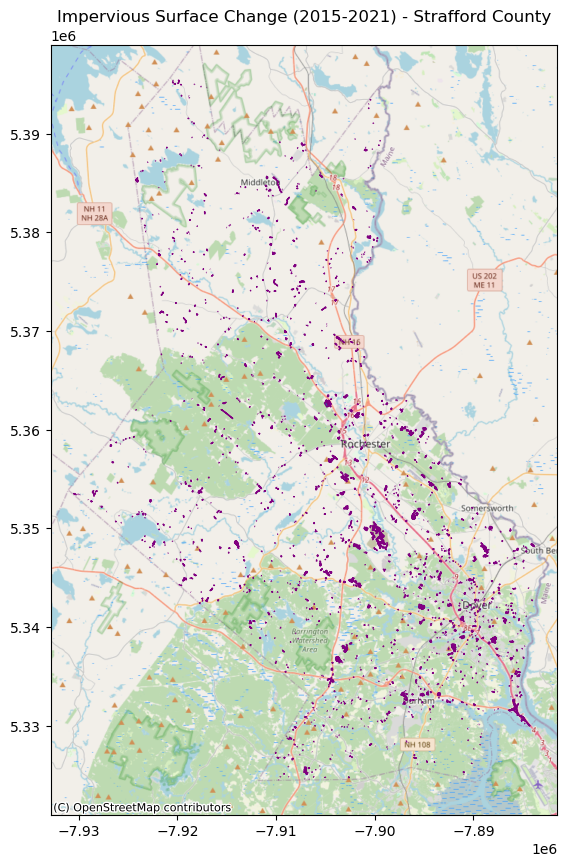

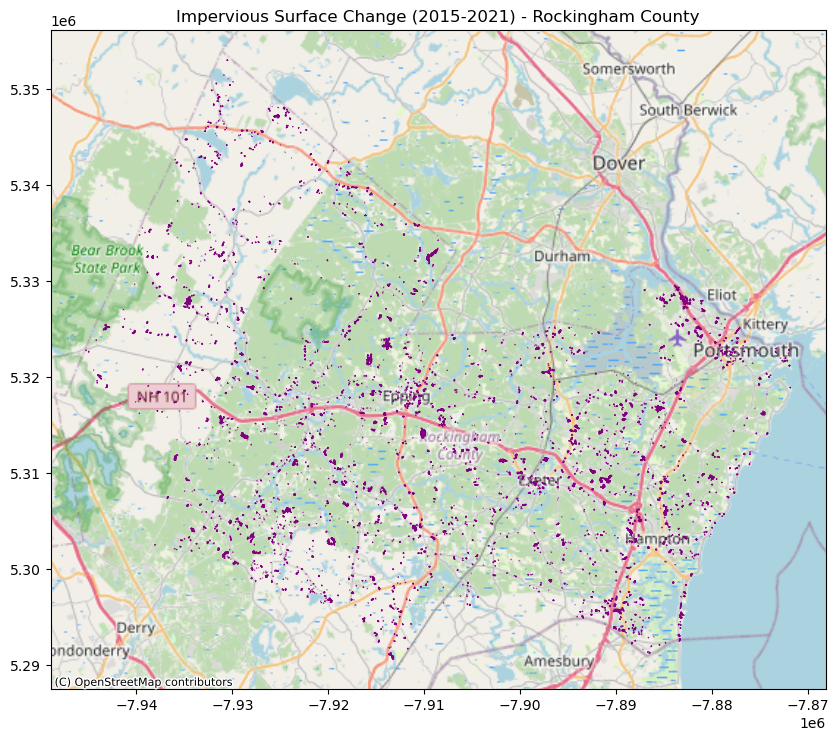

In [141]:
import geopandas as gpd
import contextily as ctx

# Create a column for changes in impervious surfaces (IC_2021 == 1 and IC_2015 == 0)
straff_imp["IC_Change"] = ((straff_imp["IC_2021"] == 1) & (straff_imp["IC_2015"] == 0)).astype(int)
rock_imp["IC_Change"] = ((rock_imp["IC_2021"] == 1) & (rock_imp["IC_2015"] == 0)).astype(int)

# Calculate the area of change in square meters for the change from 2015 to 2021
straff_imp["Area_of_Change"] = straff_imp["IC_Change"] * straff_imp["Shape_Area"]
rock_imp["Area_of_Change"] = rock_imp["IC_Change"] * rock_imp["Shape_Area"]

# Filter the data for areas where there was a change (IC_Change == 1)
strafford_change = straff_imp[straff_imp["IC_Change"] == 1]
rockingham_change = rock_imp[rock_imp["IC_Change"] == 1]

# Summarize the total change in impervious surface area
strafford_total_change_area = strafford_change["Area_of_Change"].sum()
rockingham_total_change_area = rockingham_change["Area_of_Change"].sum()

# Print results for total area changed
print(f"Total area of change in impervious surface (Strafford) in m²: {strafford_total_change_area}")
print(f"Total area of change in impervious surface (Rockingham) in m²: {rockingham_total_change_area}")

# Visualize the changes on a map
import matplotlib.pyplot as plt

# Plot for Strafford County
ax = strafford_change.plot(figsize=(10, 10), edgecolor="purple", alpha=1)
ax.set_title("Impervious Surface Change (2015-2021) - Strafford County")
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

# Plot for Rockingham County
ax = rockingham_change.plot(figsize=(10, 10), color="red", alpha=1, edgecolor="purple")
ax.set_title("Impervious Surface Change (2015-2021) - Rockingham County")
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()


In [25]:
# Create county identifiers for concatenated DF
straff_imp['County'] = 'Strafford'
rock_imp['County'] = 'Rockingham'

In [29]:
import pandas as pd
county_combo = pd.concat([straff_imp, rock_imp])

In [31]:
# Calculate total variation between 2015 and 2021
county_combo['Area_2015'] = county_combo.geometry.area * (county_combo['IC_2015'] == 1)
county_combo['Area_2021'] = county_combo.geometry.area * (county_combo['IC_2021'] == 1)

In [33]:
# Aggregate by county
impervious_agg = county_combo.groupby('County').agg(Total_Area_2015=('Area_2015', 'sum'), Total_Area_2021=('Area_2021', 'sum')).reset_index()

In [34]:
# Calculate total change
impervious_agg['Change_2015_2021'] = impervious_agg['Total_Area_2021'] - impervious_agg['Total_Area_2015']

In [36]:
impervious_agg = impervious_agg.rename(columns={'Total_Area_2015': 'Impervious_Surface_Area_2015', 'Total_Area_2021': 'Impervious_Surface_Area_2021',
                                                "Change_2015_2021": "Change_in_Impervious_Surface"})

In [39]:
reshaped_df = impervious_agg.melt(id_vars=['County', 'Change_in_Impervious_Surface'],
                                  value_vars=['Impervious_Surface_Area_2015', 'Impervious_Surface_Area_2021'],
                                  var_name='Year')

In [42]:
# Clean date data to contain year only
reshaped_df["Year"] = reshaped_df["Year"].str.extract(r"(\d{4})")

In [44]:
reshaped_df.rename(columns={'value': 'Impervious_Surface_Area'}, inplace=True)

In [46]:
import numpy as np

# Set 'Change_in_Impervious_Surface' to NaN for Rockingham 2015 and Strafford 2015
reshaped_df.loc[(reshaped_df['County'] == 'Rockingham') & (reshaped_df['Year'] == '2015'), 'Change_in_Impervious_Surface'] = np.nan
reshaped_df.loc[(reshaped_df['County'] == 'Strafford') & (reshaped_df['Year'] == '2015'), 'Change_in_Impervious_Surface'] = np.nan

# Show the result
print(reshaped_df.head())


       County  Change_in_Impervious_Surface  Year  Impervious_Surface_Area
0  Rockingham                           NaN  2015             1.521934e+08
1   Strafford                           NaN  2015             9.337719e+07
2  Rockingham                  5.474406e+06  2021             1.576678e+08
3   Strafford                  3.572016e+06  2021             9.694921e+07


In [60]:
historical_data = pd.read_csv('Data/time-series/combined_time_series.csv')

In [49]:
imp_1962_2021 = pd.concat([historical_data, reshaped_df])

In [53]:
for county in ['Strafford', 'Rockingham']:
    df_1998 = imp_1962_2021[(imp_1962_2021['County'] == county) & (imp_1962_2021['Year'] == 1998)]
    df_2015 = imp_1962_2021[(imp_1962_2021['County'] == county) & (imp_1962_2021['Year'] == '2015')]
    
    change = df_2015['Impervious_Surface_Area'].values[0] - df_1998['Impervious_Surface_Area'].values[0]
    imp_1962_2021.loc[(imp_1962_2021['County'] == county) & (imp_1962_2021['Year'] == '2015'), 'Change_in_Impervious_Surface'] = change


In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Encode county data
historical_data['County_encoded'] = label_encoder.fit_transform(historical_data['County'])
reshaped_df['County_encoded'] = label_encoder.fit_transform(reshaped_df['County'])

# Initialize values in change column for starting year to 0
historical_data.fillna(0, inplace=True)
reshaped_df.fillna(0, inplace=True)

X_part1 = historical_data[['Year', 'County_encoded']]
y_part1 = historical_data['Change_in_Impervious_Surface']

model_part1 = LinearRegression()
model_part1.fit(X_part1, y_part1)

LinearRegression()

In [71]:
# Retain regression model for later use
import joblib
joblib.dump(model_part1, 'part1_model.pkl')

['part1_model.pkl']

In [102]:
# Prepare data for estimation analysis
X_part2 = reshaped_df[['Year', 'County_encoded']]

# Predict change using trained model from historical data
reshaped_df['Predicted_Change_1962_1998'] = model_part1.predict(X_part2)

In [104]:
# Extract county data into individual DFs to scale by each county
straff_part2 = reshaped_df[reshaped_df['County'] == 'Strafford'].copy()
rock_part2 = reshaped_df[reshaped_df['County'] == 'Rockingham'].copy()

# Calculate scaling factor to adjust modern data
for df in [straff_part2, rock_part2]:
    scaling_factor = df['Predicted_Change_1962_1998'].mean() / df['Change_in_Impervious_Surface'].mean()
    df['Adjusted_Change'] = df['Change_in_Impervious_Surface'] * scaling_factor

In [105]:
# Recompile data
part2 = pd.concat([straff_part2, rock_part2])

In [ ]:
change = df_2015['Impervious_Surface_Area'].values[0] - df_1998['Impervious_Surface_Area'].values[0]

In [109]:
X_part2_adjusted = part2[['Year', 'County_encoded']]
y_part2_adjusted = part2['Adjusted_Change']

In [81]:
straff_change = reshaped_df['Impervious_Surface_Area'].values[1] - historical_data['Impervious_Surface_Area'].values[2]
rock_change = reshaped_df['Impervious_Surface_Area'].values[0] - historical_data['Impervious_Surface_Area'].values[5]


-146563697.79046708


In [82]:
rock_change = reshaped_df['Impervious_Surface_Area'].values[0] - historical_data['Impervious_Surface_Area'].values[5]

In [84]:
reshaped_df.loc[0, 'Change_in_Impervious_Surface'] = rock_change
reshaped_df.loc[1, 'Change_in_Impervious_Surface'] = straff_change

In [85]:
reshaped_df

,County,Change_in_Impervious_Surface,Year,Impervious_Surface_Area,County_encoded,Predicted_Change_1962_1998,Adjusted_Change
0,Rockingham,-5.139460e+08,2015,1.521934e+08,0,5.735313e+08,0.000000e+00
1,Strafford,-1.465637e+08,2015,9.337719e+07,1,4.810463e+08,0.000000e+00
2,Rockingham,5.474406e+06,2021,1.576678e+08,0,6.444995e+08,1.362239e+09
3,Strafford,3.572016e+06,2021,9.694921e+07,1,5.520144e+08,8.888525e+08


In [111]:
model_part2 = LinearRegression()
model_part2.fit(X_part2_adjusted, y_part2_adjusted)

LinearRegression()

In [112]:
predictions = model_part2.predict(X_part2_adjusted)

In [113]:
predictions

array([ 1.09876336e+09, -6.57026808e+07,  1.19124845e+09,  2.67824147e+07])

In [118]:
from sklearn.metrics import mean_squared_error
print(f'RMSE for Part 2 Model: {np.sqrt(mean_squared_error(y_part2_adjusted, predictions)):.2f} square meters')

RMSE for Part 2 Model: 39896217.53 square meters


In [115]:
from math import sqrt
print(sqrt(mean_squared_error(y_part2_adjusted, predictions)))

39896217.53082908


In [119]:
# Import cyanobacteria bloom data
bloom_gdf = gpd.read_file('Data/aggregated_bloom_data_buffer_1km.gpkg')

C:\Users\curti\anaconda3\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [121]:
# Save estimation prediction model
joblib.dump(model_part2, 'part2_model.pkl')
part2.to_csv('modeled_change_2015-2021.csv')

['part2_model.pkl']

In [173]:
# Split data to evaluate independently
strafford = historical_data[historical_data['County_encoded'] == 1].copy()
rockingham = historical_data[historical_data['County_encoded'] == 0].copy()

# Due to significant inaccuracies in available data, 1974 data for Rockingham is not used
rockingham.drop(index=4, inplace=True)

In [180]:
# Generate time period
strafford['Years_Elapsed'] = strafford['Year'].diff()
rockingham['Years_Elapsed'] = rockingham['Year'].diff()

# Re-evaluate Rockingham values to adjust for removed data
rockingham['Change_in_Wetlands'] = rockingham['Wetlands_Area'].diff()
rockingham['Change_in_Impervious_Surface'] = rockingham['Impervious_Surface_Area'].diff()

In [181]:
# Calculate rates of change for each 
strafford['Imp_rate'] = strafford['Change_in_Impervious_Surface'] / strafford['Years_Elapsed']
strafford['Wetland_rate'] = strafford['Change_in_Wetlands'] / strafford['Years_Elapsed']
rockingham['Imp_rate'] = rockingham['Change_in_Impervious_Surface'] / rockingham['Years_Elapsed']
rockingham['Wetland_rate'] = rockingham['Change_in_Wetlands'] / rockingham['Years_Elapsed']

In [183]:
# Calculate relationship between wetland loss and impervious surface gain in historical data
strafford['Loss_per_imp'] = strafford['Change_in_Wetlands'] / strafford['Change_in_Impervious_Surface']
rockingham['Loss_per_imp'] = rockingham['Change_in_Wetlands'] / rockingham['Change_in_Impervious_Surface']

In [188]:
# Rejoin datasets
re_df = pd.concat([rockingham, strafford])

# Factor for estimation of wetland loss
avg_loss_per_unit = re_df['Loss_per_imp'].mean()

In [192]:
# Evaluate modern data using wetland loss factor adjustment
part2['Estimated_Wetland_Change'] = part2['Adjusted_Change'] *avg_loss_per_unit

In [197]:
sw_change = 1.483965e+07 + -6.088868e+08
rw_change = 7.540909e+06 + -7.079525e+08
print(f"The estimated loss of wetlands in Strafford county is {sw_change:.2f} m^2")
print(f"The estimated loss of wetlands in Rockingham county is {rw_change:.2f} m^2")

The estimated loss of wetlands in Strafford county is -594047150.00 m^2
The estimated loss of wetlands in Rockingham county is -700411591.00 m^2


In [198]:
si_change = 1.058867e+09 + -2.580646e+07
ri_change = 1.231145e+09 + -1.311380e+07

print(f"The adjusted change in impervious surface coverage in Strafford county is {si_change:.2f} m^2")
print(f"The adjusted change in impervious surface coverage in Rockingham county is {ri_change:.2f} m^2")

The adjusted change in impervious surface coverage in Strafford county is 1033060540.00 m^2
The adjusted change in impervious surface coverage in Rockingham county is 1218031200.00 m^2
